In [143]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
os.environ["GRB_LICENSE_FILE"] = "/Users/smorales/gurobi.lic"

import gurobipy as gp
from gurobipy import GRB


# Examples

In [ ]:
# --- Fano base polytope vertices in R^7 (28 vertices) ---
FANO_POINTS = {
    0: [0, 1, 0, 0, 0, 1, 1], 1: [0, 0, 1, 0, 0, 1, 1], 2: [0, 0, 0, 1, 0, 1, 1],
    3: [0, 0, 0, 0, 1, 1, 1], 4: [1, 0, 0, 0, 1, 0, 1], 5: [0, 0, 1, 0, 1, 0, 1],
    6: [0, 0, 0, 1, 1, 0, 1], 7: [1, 0, 0, 1, 0, 0, 1], 8: [0, 1, 0, 1, 0, 0, 1],
    9: [1, 0, 1, 0, 0, 0, 1], 10: [0, 1, 1, 0, 0, 0, 1], 11: [1, 1, 0, 0, 0, 0, 1],
    12: [1, 0, 0, 0, 1, 1, 0], 13: [0, 1, 0, 0, 1, 1, 0], 14: [0, 0, 0, 1, 1, 1, 0],
    15: [1, 0, 0, 1, 0, 1, 0], 16: [0, 0, 1, 1, 0, 1, 0], 17: [1, 0, 1, 0, 0, 1, 0],
    18: [0, 1, 1, 0, 0, 1, 0], 19: [1, 1, 0, 0, 0, 1, 0], 20: [0, 1, 0, 1, 1, 0, 0],
    21: [0, 0, 1, 1, 1, 0, 0], 22: [1, 0, 1, 0, 1, 0, 0], 23: [0, 1, 1, 0, 1, 0, 0],
    24: [1, 1, 0, 0, 1, 0, 0], 25: [1, 0, 1, 1, 0, 0, 0], 26: [0, 1, 1, 1, 0, 0, 0],
    27: [1, 1, 0, 1, 0, 0, 0]
}

# remove three random points from FANO_POINTS
import random
to_remove = 7
points_to_remove = random.sample(list(FANO_POINTS.keys()), to_remove)
for p in points_to_remove:
    del FANO_POINTS[p]

# reorder keys so they go from 0 to 27 - to_remove
FANO_POINTS = {i: FANO_POINTS[k] for i, k in enumerate(FANO_POINTS.keys())}


FANO_RANK = 7

# Test for known unimodular simplices of the Fano matroid
FANO_known_unimodular_simplices = [
    (0, 1, 2, 3, 5, 9, 18),
    (3, 4, 12, 13, 14, 17, 23),
    (3, 4, 12, 14, 17, 22, 23),
    (3, 5, 6, 9, 11, 18, 23),
    (11, 15, 17, 19, 20, 22, 27)
]

# Print the removed points if any
if to_remove > 0:
    print(f"Removed points: {points_to_remove}")

In [145]:
import subprocess, json, math

def compute_volume(vertices, normalizing_factor=None, script="compute_volume.sage.py"):
    args = ['sage', '-python', script, json.dumps(vertices)]
    if normalizing_factor is not None:
        args.append(str(normalizing_factor))
    result = subprocess.run(args, capture_output=True, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"Sage error:\n{result.stderr}")
    return result.stdout.strip()

# Example:
nf = math.factorial(FANO_RANK - 1) / math.sqrt(FANO_RANK)   # keep as float
FANO_VOLUME = int(compute_volume(list(FANO_POINTS.values()), nf))
print("Volume of the Fano Polytope:", FANO_VOLUME)  # Should be 232

Volume of the Fano Polytope: 166


In [146]:
# -----------------------------------------------------------------------------
# Data for the 6 vertices of the mother of all examples 2D point configuration.
# Each has 3 coordinates that sum to 4. 

MOTHER_POINTS = {
    0: [4, 0, 0], 1: [0, 4, 0], 2: [0, 0, 4],
    3: [2, 1, 1], 4: [1, 2, 1], 5: [1, 1, 2]
}

MOTHER_RANK = 3

In [147]:
CUBE_POINTS = {
    0: [0, 0, 1, 1], 1: [0, 1, 1, 1], 2: [1, 1, 1, 1], 3: [1, 0, 1, 1],
    4: [0, 0, 0, 1], 5: [0, 1, 0, 1], 6: [1, 1, 0, 1], 7: [1, 0, 0, 1]
}

CUBE_RANK = 4

# Generate the LP to optimize over the Universal Polytope

## 1. Get unimodular simplices

In [148]:
def cayley_menger_det(indices, D2):
    """
    Cayley-Menger determinant for the simplex with vertex indices 'indices'.
    Returns (determinant, volume_squared, volume).
    For m vertices, the simplex dimension is n = m - 1.
    """
    idx = np.array(indices, dtype=int)
    m = len(idx)                       # number of vertices
    n = m - 1                          # simplex dimension
    # Build the (m+1) x (m+1) CM matrix:
    M = np.ones((m + 1, m + 1), dtype=np.float64)
    M[:m, :m] = D2[np.ix_(idx, idx)]   # top-left block = pairwise d^2
    np.fill_diagonal(M[:m, :m], 0.0)   # ensure exact 0 on diagonal
    M[-1, -1] = 0.0                    # bottom-right corner

    det = float(np.linalg.det(M))
    # The normalized factor for the Caley-Menger determinant, multiplied dimension factorial over the co-volume of the lattice squared
    factor = ((-1)**(n + 1)) / (7 * (2**n))
    vol_sq = factor * det
    # guard small negative due to FP roundoff
    vol = math.sqrt(vol_sq) if vol_sq >= 0 else 0.0
    return vol

# Find all unimodular simplices in a point configuration
def get_unimodular_simplices(points, rank):
    # Precompute pairwise squared distances
    P = np.array([points[i] for i in range(len(points))], dtype=np.float64) 
    D2 = np.sum((P[:, None, :] - P[None, :, :])**2, axis=2)
    unimodular_simplices = []
    for simplex in itertools.combinations(range(len(points)), rank):
        vol = round(cayley_menger_det(simplex, D2))
        if vol == 1:
            unimodular_simplices.append(simplex)
    return unimodular_simplices

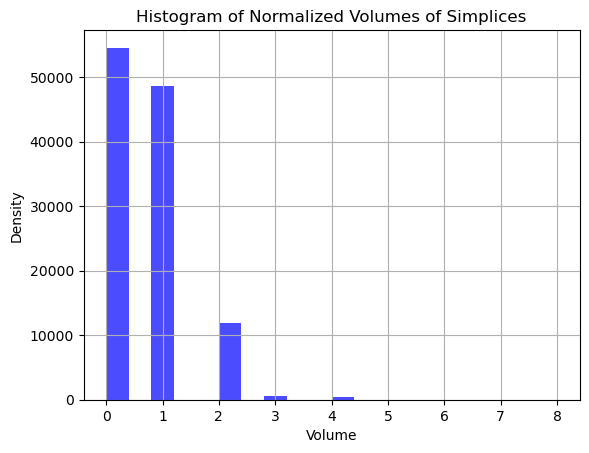

Unique volumes: [0, 1, 2, 3, 4, 8]


In [149]:
# For testing print a histogram of the normalized volumes of all the simplices
def print_volume_histogram(simplices):
    volumes = []
    unique_volumes = set()

    # Precompute pairwise squared distances
    P = np.array([FANO_POINTS[i] for i in range(len(FANO_POINTS))], dtype=np.float64) 
    D2 = np.sum((P[:, None, :] - P[None, :, :])**2, axis=2)

    for s in simplices:
        vol = round(cayley_menger_det(s, D2))
        volumes.append(vol)
        unique_volumes.add(round(vol))
    
    plt.hist(volumes, bins=20, density=False, alpha=0.7, color='blue')
    plt.title('Histogram of Normalized Volumes of Simplices')
    plt.xlabel('Volume')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
    print(f"Unique volumes: {sorted(unique_volumes)}")

print_volume_histogram(itertools.combinations(range(len(FANO_POINTS)), 7))

In [150]:
test = get_unimodular_simplices(FANO_POINTS, FANO_RANK)
print(f"Found {len(test)} unimodular simplices for the fano matroid polytope.")

Found 48667 unimodular simplices for the fano matroid polytope.


## 2. Compute the Chirotope

In [151]:
# Initialize the chirotope dictionary by computing the simplices

def initialize_chirotope(point_configuration, rank, tolerance=1e-13):
    n = len(point_configuration)
    chirotope = {}
    possible_simplices = itertools.combinations(range(n), rank)
    for comb in possible_simplices:
        simplex = tuple(comb)
        det = np.linalg.det(np.array([point_configuration[i] for i in simplex]))
        if abs(det) < tolerance:
            chirotope[simplex] = 0
        else:
            chirotope[simplex] = np.sign(det)
    return chirotope

### Testing

In [152]:
# print times for the mother and the fano examples
mother_start = time.time()
mother_chirotope = initialize_chirotope(MOTHER_POINTS, MOTHER_RANK)
mother_end = time.time()
print(f"Mother chirotope initialized in {mother_end - mother_start:.6f} seconds.")  
fano_start = time.time()
fano_chirotope = initialize_chirotope(FANO_POINTS, FANO_RANK)
fano_end = time.time()
print(f"Fano chirotope initialized in {fano_end - fano_start:.6f} seconds.")

Mother chirotope initialized in 0.000128 seconds.
Fano chirotope initialized in 0.502386 seconds.


## 3. Encode the Wall inequalities

In [153]:
# Get the list of simplex facets of the point configuration (every r - 1 subset of the non-zero chirotope simplices)
def get_simplex_facets(chirotope, rank):
    facets = []
    for simplex, sign in chirotope.items():
        if sign != 0:
            for facet in itertools.combinations(simplex, rank - 1):
                facets.append(facet)
    return sorted(list(set(facets))) # return unique facets

In [154]:
# Testing on the mother of all examples, print the simplex facets
mother_facets = get_simplex_facets(mother_chirotope, MOTHER_RANK)
print(f"Mother of all examples has {len(mother_facets)} facets.")
print(mother_facets)

Mother of all examples has 15 facets.
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [155]:
# Find the co-circuit signatures for each facet 
# Output a tuple of two lists for each simplex facet: negative and postive signatures
# The sign of the permutation is considered
def find_cocircuit_signatures(chirotope, facets, n):
    cocircuit_signatures = {}
    # for each facet, go through all vertices not in the facet
    # find the number of inversions (r - index of the vertex in the ordered simplex)
    r = len(facets[0]) + 1
    for facet in facets:
        negative_signatures = []
        positive_signatures = []
        facet_set = set(facet)
        for vertex in range(n):
            if vertex not in facet_set:
                # Create the full simplex by adding the vertex
                full_simplex = list(facet) + [vertex]
                full_simplex.sort()
                # Account for the sign of the permutation
                correction = (r - full_simplex.index(vertex)) % 2 
                sign = chirotope.get(tuple(full_simplex)) * (-1)**correction
                if sign == -1:
                    negative_signatures.append(vertex)
                elif sign == 1:
                    positive_signatures.append(vertex)
        cocircuit_signatures[facet] = (negative_signatures, positive_signatures)
    return cocircuit_signatures

### Wall inequalities

In [156]:
# Start encoding the constraints for gurobi (gurobipy)
def get_wall_inequalities(chirotope, facets, n):
    cocircuit_signatures = find_cocircuit_signatures(chirotope, facets, n)
    inequalities = []
    for facet, (negatives, positives) in cocircuit_signatures.items():
        if negatives and positives:  # Only consider facets with both signs (they are interior walls)
            positive_simplices = [tuple(sorted(facet + (v,))) for v in positives]
            negative_simplices = [tuple(sorted(facet + (v,))) for v in negatives]
            inequalities.append([positive_simplices, negative_simplices])
    return inequalities

In [157]:
# Initialize the gurobi model for the fano matroid example
m = gp.Model()

x = {}
# add variables for each simplex with non-zero chirotope value
for simplex, sign in fano_chirotope.items():
    if sign != 0:
        x[simplex] = m.addVar(vtype=GRB.BINARY, name=f"x_{simplex}")

# add constraints for each wall inequality
fano_facets = get_simplex_facets(fano_chirotope, FANO_RANK)
fano_wall_inequalities = get_wall_inequalities(fano_chirotope, fano_facets, len(FANO_POINTS))
for idx, (positives, negatives) in enumerate(fano_wall_inequalities):
    expr = gp.LinExpr()
    for simplex in positives:
        expr += x[simplex]
    for simplex in negatives:
        expr -= x[simplex]
    # positives minus negatives = 0
    m.addConstr(expr == 0, name=f"wall_{idx}")

m.update()
# print some info about the model so far
print(f"Model has {m.numVars} variables and {m.numConstrs} constraints.")

Model has 61708 variables and 39266 constraints.


## 4. Encode the (assuming unimodular) Flag inequalities

In [158]:
# add a variable for each 2-subset (edge) of the 28 vertices
for edge in itertools.combinations(range(len(FANO_POINTS)), 2):
    x[edge] = m.addVar(vtype=GRB.BINARY, name=f"x_{edge}")

# Go through the simplices, for each one, add a constraint to activate the edges if the simplex is active
for simplex in fano_chirotope.keys():
    if fano_chirotope[simplex] != 0:
        for edge in itertools.combinations(simplex, 2):
            m.addConstr(x[simplex] <= x[edge], name=f"simplex_edge_{simplex}_{edge}")


# create a dictionary such that for each triangle, we have the list of simplices that contain it (do it efficiently)
triangle_to_simplices = {}
for simplex in fano_chirotope.keys():
    if fano_chirotope[simplex] != 0:
        for triangle in itertools.combinations(simplex, 3):
            if triangle not in triangle_to_simplices:
                triangle_to_simplices[triangle] = []
            triangle_to_simplices[triangle].append(simplex)

print(f"Number of triangles: {len(triangle_to_simplices)}")

# For each triangle, add a constraint that if the three edges of a triangle are active, at least one of the simplices containing it is active
for triangle, simplices in triangle_to_simplices.items():
    expr = gp.LinExpr()
    for edge in itertools.combinations(triangle, 2):
        expr += x[edge]

    for simplex in simplices:
        expr -= x[simplex]
    m.addConstr(expr <= 2, name=f"triangle_{triangle}")


m.update()
# print some info about the model so far
print(f"Model has {m.numVars} variables and {m.numConstrs} constraints.")



Number of triangles: 1330
Model has 61918 variables and 1336464 constraints.


## 5. Optimize

In [159]:
# Add the volume constraint: sum of the simplices = 232
volume_expr = gp.LinExpr()
for simplex, sign in fano_chirotope.items():
    if sign != 0:
        volume_expr += x[simplex]
m.addConstr(volume_expr == FANO_VOLUME, name="volume_constraint")

# maximize the number of activated simplices
obj = gp.LinExpr()
for simplex, sign in fano_chirotope.items():
    if sign != 0:
        obj += x[simplex]
m.setObjective(obj, GRB.MAXIMIZE)
m.update()

In [ ]:
lp = m.relax()
lp.setParam("OutputFlag", 1)       # make sure logging is on
lp.setParam("DisplayInterval", 1)  # print progress every iteration
lp.setParam("Method", -1)          # let Gurobi choose the LP algorithm (default)
lp.setParam('TimeLimit', 3600)  # 1 hour time limit

print("Objective should be the volume:", FANO_VOLUME)

lp.optimize()

Set parameter DisplayInterval to value 1
Set parameter TimeLimit to value 3600
Objective should be the volume: 166
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1336465 rows, 61918 columns and 5200322 nonzeros
Model fingerprint: 0xa01d9ca0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 0 rows and 0 columns (presolve time = 1s) ...
Presolve removed 0 rows and 0 columns (presolve time = 2s) ...
Presolve removed 0 rows and 0 columns (presolve time = 3s) ...
Presolve removed 0 rows and 0 columns (presolve time = 4s) ...
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve removed 0 rows and 0 columns (presolve time = 7s) ..

In [ ]:
print(lp.status)        # 2=optimal, 3=infeasible, 4=infeasible or unbounded, 5=unbounded

In [ ]:
# Interpret the results
if m.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    activated_simplices = [var.varName for var in m.getVars() if var.varName.startswith('x_(') and var.x > 0.5]
    activated_edges = [var.varName for var in m.getVars() if var.varName.startswith('x_(') and var.x > 0.5 and len(eval(var.varName[2:])) == 2]
    print(f"Activated simplices ({len(activated_simplices)}): {activated_simplices}")
    print(f"Activated edges ({len(activated_edges)}): {activated_edges}")


# Running examples

## 1. The mother of all examples (2D)

## 2. The Fano Matroid Polytope (3D)